Exploration of activity changes

This notebook explores the following features of neural activity:

- Decoding
    - Using
        - Logistic Regression
        - Random forest
        - XGBoost
    - Model characteristics
        - Confusion matrix
        - "Distance"/"predict_proba" matrices
        - Feature importances
    - Comparing
        - Before/after changepoint
        - Autoshape/DRRD
        

- Differences
    - Comparing
        - Before/after changepoint
        - Autoshape/DRRD
    - Measures 
        - Distances
        - Similarities
        - Synchronization
        - Via spikeutils

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Feature-importances" data-toc-modified-id="Feature-importances-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature importances</a></div><div class="lev2 toc-item"><a href="#XGBoost" data-toc-modified-id="XGBoost-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>XGBoost</a></div><div class="lev2 toc-item"><a href="#ElasticNet" data-toc-modified-id="ElasticNet-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ElasticNet</a></div><div class="lev2 toc-item"><a href="#rbfSVM" data-toc-modified-id="rbfSVM-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>rbfSVM</a></div><div class="lev2 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Logistic Regression</a></div>

# Imports

In [158]:
def encode_by_rate_quantile(X, q):
    le, oh = LabelEncoder(), OneHotEncoder()
    
    df = pd.DataFrame(X).apply(lambda x: pd.qcut(x, q, duplicates='drop'))
    df = df.apply(lambda x: le.fit_transform(x))
    sp = pd.DataFrame(index=df.index)
    
    for i in df.columns:
        sp = sp.join(pd.DataFrame(oh.fit_transform(df[i].values.reshape(-1,1)).todense()), rsuffix='_unit_%d'%i, lsuffix='_unit_%d'%i)
    
    return sp

In [423]:
df = encode_by_rate_quantile(X, 10)

In [14]:
import os
os.chdir('../../')

import pandas as pd
import numpy as np

In [15]:
from sklearn.model_selection import GroupShuffleSplit, cross_val_predict, GroupKFold
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [16]:
from spikelearn.data import io
from spikelearn.data.selection import select, to_feature_array

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [343]:
def shuffle_val_predict(clf, X, y, group=None, cv=GroupKFold(5), get_weights = True):
    def get_predictions_or_proba(clf, X, mode):
        """
        Local helper function to ease the switching between predict_proba and predict
        """
        if mode == 'predict':
            return pd.DataFrame(clf.predict(X), columns=['predictions'])
        elif mode in ['proba','probability']:
            try:
                return pd.DataFrame(clf.predict_proba(X), columns=np.unique(y))
            except:
                return pd.DataFrame(clf.decision_function(X), columns=np.unique(y))

    weights = pd.DataFrame()
    results = pd.DataFrame()
    n_y = len(np.unique(y))
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y, group)):
        clf_local = clone(clf)
        clf_local.fit(X[train_idx,:],y[train_idx])

        for train_or_test in ['train', 'test']:
            idx = test_idx if train_or_test is 'test' else train_idx
            predictions = get_predictions_or_proba(clf_local, X[idx], 'proba')
            predictions['cv'] = i
            predictions['group'] = group[idx]
            predictions['true'] = y[idx]
            predictions['predictions'] = predictions.apply(lambda x: x.index[np.argmax(x.values[:n_y])], axis=1)
            predictions['mean'] = predictions.apply(lambda x: np.sum(predictions.columns[:10].values*x.values[:10]), axis=1)
            predictions['set'] = train_or_test
            results = results.append(predictions)

        if get_weights:
            w = pd.DataFrame(clf_local.coef_, columns = np.arange(X.shape[1]), index = pd.Index(np.unique(y).astype(int), name='time'))
            w = w.reset_index().melt(var_name='unit', id_vars=['time'])
            w['shuffle'] = i
            weights=weights.append(w)
    if get_weights:
        return results, weights
    return results

In [340]:
 res.columns[:10].values

array([200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0,
       1100.0], dtype=object)

In [356]:
res['mean'] = res.apply(lambda x: np.sum(res.columns[:10].values*x.values[:10]), axis=1)

In [333]:
predictions['predictions'] = predictions.apply(lambda x: x.index[np.argmax(x.values[:n_y])], axis=1)

NameError: name 'predictions' is not defined

In [ ]:
res

In [28]:
data = io.load('DRRD 8', 'narrow_smoothed')

data = select(data, _min_duration=1.5)
X,y, trial = to_feature_array(data)

X = ss.fit_transform(X)

In [68]:
res, weights = shuffle_val_predict(LogisticRegression(), X, y, trial, cv=sh, get_weights = True)

# Feature importances

## XGBoost

In [9]:
from xgboost import XGBClassifier

In [12]:
def xgb(label, method = 'proba'):
#     params = io.load(rat, 'XGboost')
#     params = dict(zip(params.columns, params.values.reshape(-1)))
#     params['max_depth'] = int(params['max_depth'])
#     params['n_estimators'] = int(params['n_estimators'])
#     params['min_child_weight'] = int(params['min_child_weight'])
    clf = XGBClassifier(n_estimators=12, subsample=.5, gamma=0.1, max_depth=16)
    
    s = io.load(label, 'wide_smoothed')
    X,y, trial = to_feature_array(select(s.reset_index(), _min_duration=1.5, _min_trial=100, is_tired=False).set_index(['trial','unit']), subset='cropped')
    
    res = shuffle_val_predict(clf, X, y, trial, GroupShuffleSplit(30, 10, 80),method)
    clf = clf.fit(X, y)
    
    return res, clf

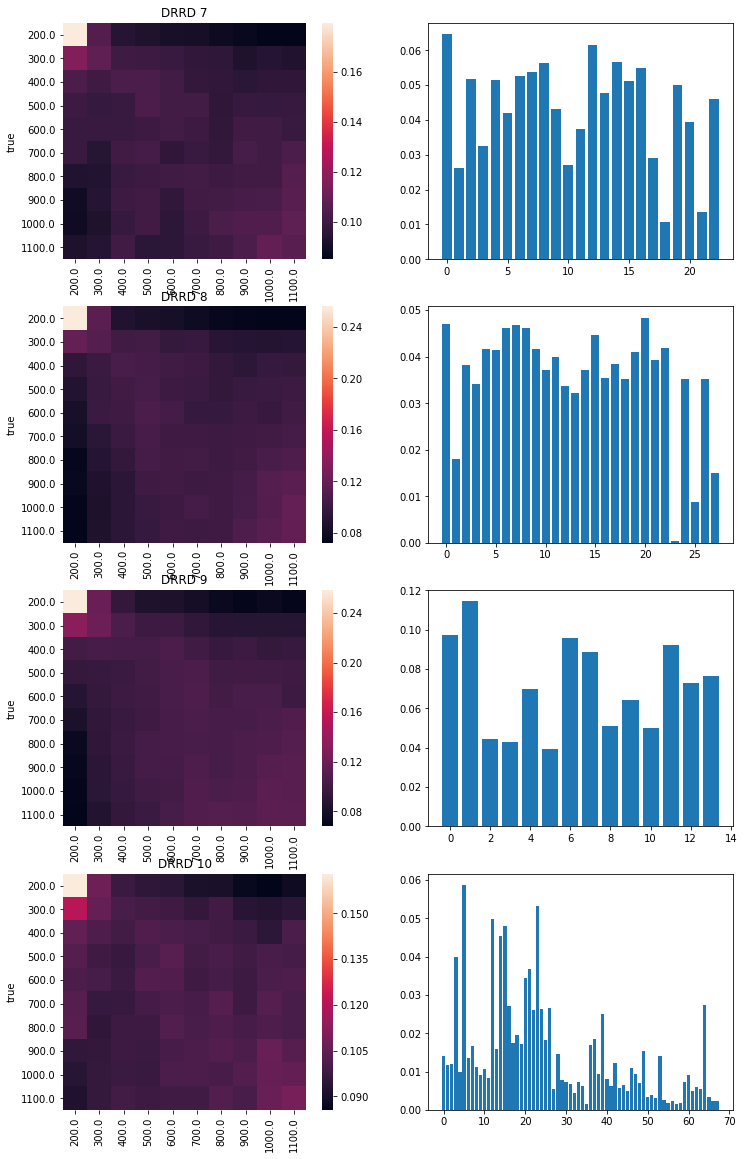

In [61]:
plt.figure(figsize=(12, 20))
for i, rat in enumerate(['DRRD %d'%n for n in [7,8,9,10]]):
    res, clf = xgb(rat)
    
    plt.subplot(4, 2, 2*i+1)
    sns.heatmap(res.drop(['cv','group'],axis=1).groupby('true').mean()); plt.title(rat)
    plt.subplot(4, 2, 2*i+2)
    plt.bar(np.arange(clf.feature_importances_.shape[0]),clf.feature_importances_)

In [17]:
res, clf = xgb('DRRD 8', 'predict')

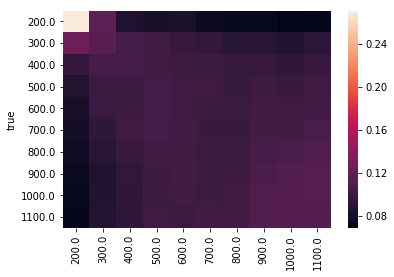

In [16]:
sns.heatmap(res.drop(['cv','group'],axis=1).groupby('true').mean())

---

In [58]:
def normalized_distance(mean, observations, max_qdist):
    print(mean, max_qdist)
    norm_dist = np.sum((observations-mean)**2)/max_qdist
    return 1 - norm_dist/len(observations)

def multiclass_pessimistic_score(y_true, y_pred, composite='min',
                        one_class_score_func=normalized_distance, labels=None):
    if labels is None:
        labels = np.unique(y_true)

    each_score = np.array([one_class_score_func(y, y_pred[y_true==y], max(y-min(labels), max(labels)-y)**2 ) for y in labels])
    
    if composite == 'geometric':
        return np.prod(each_score)**(1/len(each_score))
    elif composite == 'harmonic':
        eps = 1e-6
        return len(each_score)/(np.sum(1/(each_score+eps)))
    elif composite == 'min':
        return min(each_score)


## ElasticNet

In [59]:
from sklearn.linear_model import SGDClassifier

In [81]:
params = io.load('DRRD 8', 'elasticnet_SGD')
params= dict(zip(params.columns, params.values.reshape(-1)))

In [105]:
clf = SGDClassifier(loss='log', penalty='elasticnet',
                                    tol=1e-5, **params)

In [64]:
data = io.load('DRRD 8', 'wide_smoothed')

In [123]:
X,y,trial = to_feature_array(select(data, _min_duration=1.500))
y = y.astype(int)

In [107]:
l = LabelEncoder()
t = l.fit_transform(results.true)
p = l.transform(results.predictions)

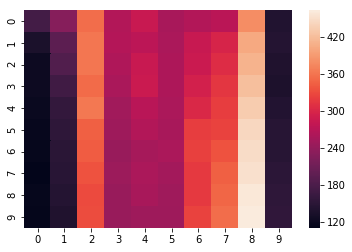

In [108]:
sns.heatmap(confusion_matrix(t, p))

## rbfSVM

In [148]:
from sklearn.svm import SVC

In [145]:
params = io.load('DRRD 7', 'rbfSVM')
params= dict(zip(params.columns, params.values.reshape(-1)))

In [149]:
clf = SVC(**params)

In [150]:
def get_predictions_or_proba(clf, X, mode):
    """
    Local helper function to ease the switching between predict_proba and predict
    """
    if mode == 'predict':
        return clf.predict(X)
    elif mode in ['proba','probability']:
        try:
            return clf.predict_proba(X)
        except:
            return clf.decision_function(X)
n_shuffles=10
train_size=.8
test_size=.2

results = pd.DataFrame(columns = ['trial', 'shuffle', 'predictions','true'])
sh = GroupShuffleSplit(n_splits=n_shuffles, train_size=train_size,test_size=test_size)

for i, (train_idx, test_idx) in enumerate(sh.split(X,y,trial)):
    clf_local = clone(clf)
    clf_local.fit(X[train_idx,:],y[train_idx])

    predictions = get_predictions_or_proba(clf_local, X[test_idx], 'predict' )
    true = y[test_idx]
    results = results.append(pd.DataFrame({'shuffle':i, 'predictions': predictions,
                                            'trial':trial[test_idx], 'true':true} ) )

In [151]:
l = LabelEncoder()
t = l.fit_transform(results.true)
p = l.transform(results.predictions)

In [152]:
confusion_matrix(t,p)

array([[793,  83,  45,  49,  43,  39,  30,  41,  50, 137],
       [759,  76,  37,  64,  49,  42,  29,  50,  57, 147],
       [728,  76,  35,  71,  49,  43,  40,  57,  61, 150],
       [705,  64,  31,  78,  57,  46,  41,  67,  67, 154],
       [673,  72,  35,  70,  65,  52,  42,  66,  79, 156],
       [645,  72,  39,  69,  69,  57,  50,  76,  71, 162],
       [639,  70,  35,  69,  69,  61,  51,  82,  74, 160],
       [632,  72,  36,  73,  65,  58,  52,  84,  79, 159],
       [627,  74,  34,  73,  58,  60,  50,  85,  82, 167],
       [623,  80,  35,  77,  54,  56,  49,  89,  79, 168]])

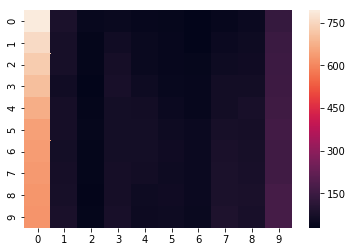

In [153]:
sns.heatmap(confusion_matrix(t, p))

## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
ss = StandardScaler()

In [472]:
times = np.unique(y)/1000
idxtimes = pd.Index(times, name='Time from onset(s)')

In [473]:
conf = pd.DataFrame(confusion_matrix(res.true, res.predictions),index=idxtimes,columns=idxtimes)

In [20]:
from ipywidgets import interact
import ipywidgets.widgets as wdg

In [21]:
from IPython.display import display

In [22]:
from itertools import count
from IPython.display import clear_output, update_display

In [23]:
%matplotlib inline

In [81]:
from scipy.stats import pearsonr

In [82]:
pearsonr(res.true, res.prediction)
pearsonr(res.true, res.prediction)

(0.30750803028369411, 0.0)

In [96]:
test = res.groupby('set').get_group('test')

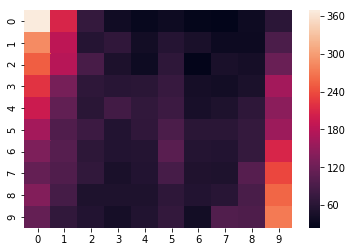

In [99]:
sns.heatmap(confusion_matrix(test.true, test.prediction))


In [138]:
from ipywidgets import HBox

In [144]:
from ipywidgets import interactive_output

In [161]:
weights.abs().groupby('unit').mean().value

DataError: No numeric types to aggregate

In [ ]:
pd.DataFrame.pivot()

In [ ]:
pd.DataFrame.set_index()

In [208]:
.reset_index().set_index('index', drop=False).pivot(columns='index')

SyntaxError: invalid syntax (<ipython-input-208-dacf8095b598>, line 1)

Rate                                                              \
trial       9         33        35        38        41        47        50     
200.0   0.160459  0.189288 -0.351279 -0.199872 -0.684509 -0.103714 -0.683743   
300.0  -0.332341  0.835852  0.120863  1.136416 -0.684509 -0.061413 -0.458941   
400.0   0.385538  2.315798 -0.279502  0.842739 -0.654777 -0.139637  0.212507   
500.0   0.732077  0.979454  0.149251  1.120480 -0.078216  0.312376  0.564965   
600.0   0.300873 -0.410623  0.183315  0.084980 -0.103714  0.372262  0.578710   
700.0  -0.561552 -0.357302  0.903607  0.351208 -0.630589  0.268102 -0.593245   
800.0  -0.669481  0.822689  0.641301  0.516918  0.054569 -0.495412 -0.684509   
900.0  -0.118489  0.156588  1.565982  0.568796  0.749889 -0.684509 -0.684509   
1000.0  0.855549  0.360851  1.315257  0.878544  0.332346 -0.684509 -0.676308   
1100.0  0.567691  0.360199  1.599543  0.223231  0.884776 -0.681971 -0.265572   

                                        ...                                   \
trial       52        54        63      ...         1660      1661      1662   
200.0  -0.684509 -0.653294 -0.618465    ...    -0.684509 -0.578962  0.255915   
300.0  -0.684509 -0.069833  0.519700    ...    -0.630869  0.510147  0.429329   
400.0  -0.660161 -0.112313  1.333671    ...     0.375445  0.922568 -0.160091   
500.0  -0.112313 -0.660161  0.243111    ...     0.626436  0.088131  0.233040   
600.0  -0.069833 -0.675183  0.565502    ...     0.070819 -0.637122  0.244572   
700.0  -0.653294 -0.168798  1.398081    ...    -0.137069 -0.533352  0.025939   
800.0  -0.662894  0.845981  1.176616    ...    -0.038227  0.462979  0.163746   
900.0   0.203839 -0.222829 -0.163001    ...     0.878262  2.002850 -0.003862   
1000.0  2.015147  0.002733 -0.641949    ...     0.864067  1.379080  0.771991   
1100.0  1.521741  0.529492 -0.053279    ...     1.186228 -0.521921  1.552055   

                                                                              
trial       1664      1665      1667      1668      1669      1670      1671  
200.0  -0.677330 -0.684509 -0.684509 -0.684509 -0.684509 -0.684509 -0.684509  
300.0  -0.294337 -0.684509 -0.684509 -0.684509 -0.675278 -0.684509 -0.684509  
400.0   0.082143 -0.684509 -0.684509 -0.650150 -0.056022 -0.684509 -0.684509  
500.0  -0.444746 -0.684509 -0.684509 -0.003749  0.938128 -0.684509 -0.684509  
600.0   0.156903 -0.684509 -0.684509  0.564225  0.166163 -0.684509 -0.684509  
700.0  -0.445903 -0.684509 -0.684509 -0.177688 -0.095161 -0.684509 -0.684509  
800.0  -0.683423 -0.684509 -0.684509 -0.670311 -0.657576 -0.684509 -0.684509  
900.0  -0.661378 -0.623109 -0.684509 -0.684509 -0.684509 -0.684509 -0.684509  
1000.0 -0.120952  0.044676 -0.684509 -0.666760 -0.673947 -0.684509 -0.684509  
1100.0 -0.061519 -0.186809 -0.684509 -0.164568 -0.243221 -0.684509 -0.684509  

[10 rows x 1030 columns]

In [397]:
srat = wdg.Dropdown(options=['DRRD %d'%i for i in [7,8,9,10]])
sdset = wdg.Dropdown(options=['narrow_smoothed', 'wide_smoothed'])
snsplits = wdg.IntSlider(min=1,max=10)

d = HBox([srat,sdset,snsplits])


def choose_rat(label, n_splits, dset):
    data = io.load(label, dset)

    
    # TODO change selection to inside, and add selection 'range'
    data = select(data, _min_duration=1.5)
    Xab, y, trial = to_feature_array(data)
    X = ss.fit_transform(Xab)
    
    sh = GroupShuffleSplit(n_splits=n_splits, train_size=.8,test_size=.2)
    
    @interact(logC=wdg.FloatSlider(min=-6, max=8,step=.25, continuous_update=False), penalty=wdg.Dropdown(options=['l1','l2']))
    def choose_regularization(logC, penalty):
        clf = LogisticRegression(C=10**logC, penalty=penalty)
        allres = pd.DataFrame()
        fig, ax = plt.subplots(2, 2, figsize=(20,8));
        #disp =display(fig,display_id='fig')
        res, weights = shuffle_val_predict(clf, X, y, trial, cv=sh, get_weights = True)
        #allres = allres.append(res.groupby('true').mean().drop(['cv', 'group'],axis=1)).groupby('true').mean()
        train = res.groupby('set').get_group('train')
        test  = res.groupby('set').get_group('test')

        train_proba = train.groupby('true').mean().drop(['cv', 'group','predictions', 'mean'],axis=1)
        test_proba = test.groupby('true').mean().drop(['cv', 'group','predictions', 'mean'],axis=1)

        # Plot train results
        
        axt = plt.subplot(2,4,1);    sns.heatmap(train_proba, ax=axt, cbar=False); plt.title('Train probabilities')
        axt = plt.subplot(2,4,2);    sns.heatmap(confusion_matrix(train.true, train.predictions), ax=axt, cbar=False); plt.title('Train predictions')

        # Plot test results
        axt = plt.subplot(2,4,5);    sns.heatmap(test_proba, ax=axt, cbar=False); plt.title('Test probabilities')
        axt = plt.subplot(2,4,6);    sns.heatmap(confusion_matrix(test.true, test.predictions), ax=axt, cbar=False); plt.title('Test predictions')

        # Weights
        axt = plt.subplot(2,4,3)
        sns.barplot('unit','value', data=weights.abs(), ax=axt); plt.title('(abs) Weight of each neuron')
        plt.ylim([0,.5])
        
        axt = plt.subplot(2,4,4)
        weights = weights.applymap(abs).groupby('unit').mean().reset_index().value
        w = (weights.sort_values()/weights.max()).values **2
        rank = weights.argsort().values
        
        activity = pd.DataFrame(X[:,rank], index=y).reset_index().groupby('index')
        mean = activity.mean()
        std = activity.std()/np.sqrt(np.unique(trial).shape[0])
        
        c = sns.palettes.color_palette('viridis', X.shape[1])
        for i, line in mean.transpose().iterrows():
            plt.plot(line, alpha=w[i], linewidth=4*(i**1.1)/X.shape[1], color=c[i])
            plt.fill_between(np.unique(y), line+std[i], line-std[i], alpha=w[i]/2, color=c[i])
        plt.title('Mean activity of neurons')
            
        train_r = pearsonr(train.true, train['mean'])[0]
        test_r = pearsonr(test.true, test['mean'])[0]
        rs = pd.DataFrame([train_r, test_r],index=['Train','Test'], columns =['r']).reset_index()
        
        sns.barplot('r','index',data=rs,ax=plt.subplot(4,4,11)); plt.xlim([0,0.5]); plt.title('Score using expected value')
        
        train_r = pearsonr(train.true, train.predictions)[0]
        test_r = pearsonr(test.true, test.predictions)[0]
        rs = pd.DataFrame([train_r, test_r],index=['Train','Test'], columns =['r']).reset_index()
        sns.barplot('r','index',data=rs,ax=plt.subplot(4,4,15)); plt.xlim([0,0.5]); plt.title('Score using maximum likelihood')
        
        plt.tight_layout()
        
        
        
out = interactive_output(choose_rat, dict(label=srat, n_splits = snsplits, dset = sdset))
display(d, out)

HBox(children=(Dropdown(options=('DRRD 7', 'DRRD 8', 'DRRD 9', 'DRRD 10'), value='DRRD 7'), Dropdown(options=('narrow_smoothed', 'wide_smoothed'), value='narrow_smoothed'), IntSlider(value=1, max=10, min=1)))

Output()